# A quick tutorial on using Wosis

Before we start, some known issues:

* Methods - especially plotting - switch from relying on Pandas DataFrames to Metaknowledge Collections.
This is because somethings are easier to accomplish with one or the other. In the future, I hope to consolidate these to use just one, not a mishmash of both. 

* Some documentation is currently missing

Suggestions on how to improve usability is appreciated, and can be made by [submitting an issue](https://github.com/ConnectedSystems/wosis/issues) with a 'usability' tag.

The cell below shows the Python version in use for this guide. Versions equal to and above should be fine.

In [1]:
import sys
print(sys.version_info)

sys.version_info(major=3, minor=5, micro=6, releaselevel='final', serial=0)


There are two options to install Wosis for development use:

1) clone the project with `git` (the dollar sign represents the terminal prompt)

```bash
$ git clone https://github.com/ConnectedSystems/wosis.git
$ cd wosis
$ python setup.py develop
```

2) download, and extract, the project files from the [github repo](https://github.com/ConnectedSystems/wosis) (look for the green button on the right hand side)

```bash
$ python setup.py develop
```

Import packages

In [2]:
import wosis
import pandas as pd
import metaknowledge as mk
import json

Load Web of Science configuration file (this assumes the relevant file is in the same place as this notebook).

Remember not to share this file with anyone, or store it in a publicly accessible repository of any sort.

The `config.yml` file should hold your Web of Science username and password, like so:

```yaml
wos:
  user: username
  password: password
```

In [3]:
wos_config = wosis.load_config("config.yml")

Create a dictionary of search terms.

In [4]:
# dollar sign ($) is a wildcard used to match British and American spellings
# e.g. flavo$r matches both flavour and flavor
# see https://images.webofknowledge.com/images/help/WOS/hs_wildcards.html
search_terms = {
    "inclusive_kw": ("Integrated Model$ing", ),  # Keywords to include (NOTE THE TRAILING COMMA FOR SINGLE ENTRIES)
    "exclusive_kw": ("chemical", "industry", "cancer", "gene"), # Keywords to exclude
    "exclusive_jo": ('PSYCHOL*', ),  # Journals to exclude (the * tries to match anything after 'PSYCHOL')
    "subject_area": ("ENVIRONMENTAL SCIENCES", "WATER RESOURCES", "ENGINEERING ENVIRONMENTAL", "INTERDISCIPLINARY APPLICATIONS"),
}

Then build a list of queries.

The below generates a query string that we will send to Web of Science. Look at the guide here for an explanation:

http://ipscience-help.thomsonreuters.com/wosWebServicesLite/WebServiceOperationsGroup/WebServiceOperations/g2/user_query.html

In [5]:
topics = [wosis.build_query(search_terms), ]
topics

['TS=(("Integrated Model$ing") NOT ("chemical" OR "industry" OR "cancer" OR "gene")) NOT SO=("PSYCHOL*") AND WC=("ENVIRONMENTAL SCIENCES" OR "WATER RESOURCES" OR "ENGINEERING ENVIRONMENTAL" OR "INTERDISCIPLINARY APPLICATIONS")']

Now we send off the query.

Strangely, the time span of interest is not accepted as part of the WoS query, but we can specify this separately.

The `%%time` Jupyter magic command is there so we know how long this process took.

For very large amounts of records, getting the data can take a long time.

Sometimes the retrieval process fails - this could be due to high amounts of traffic to the WoS servers. Most times there's no other option other than to try again.

In [6]:
%%time
overwrite = False  # Do not overwrite previous identical search if it exists
id_to_query, query_recs = wosis.query(topics, overwrite, wos_config, time_span={'begin': '2014-01-01', 'end': '2017-12-31'})

Authenticated (SID: 7D1TUbzAEFGqeKPfbvO)


c:\userdata\takuyai\owncloud\projects\wosis\wosis\query.py:267: UserWarning: Using cached results...
  warnings.warn("Using cached results...")


Got 272 records
Wall time: 1.94 s


`id_to_query` is a dictionary that maps a result ID to the query that was sent.

`query_recs` is a dictionary that maps a result ID to the matching publication set.

So, we can write out the query_id information so that we know what data is related to which query.

This is handy for later analysis/inspection:

In [7]:
with open('tmp/example_query_id.txt', 'w') as file:
     file.write(json.dumps(id_to_query, indent=2))  # use `json.loads` to do the reverse

In [8]:
# Get the ID of the query result set:
query_id = list(id_to_query)[0]

print("Query ID: ", query_id, "\nQuery String:", id_to_query[query_id], "\n")

# Load it in as a metaknowledge collection
RC = mk.RecordCollection("tmp/{}.txt".format(query_id))

# If we want to constrain the time frame later, this is how we do it
# RC = RC.yearSplit(0, 2017)

print("Corpora consists of", len(RC), "Publications")

Query ID:  72e7af00b238db01d2b12d9a3c6a4fb6 
Query String: TS=(("Integrated Model$ing") NOT ("chemical" OR "industry" OR "cancer" OR "gene")) NOT SO=("PSYCHOL*") AND WC=("ENVIRONMENTAL SCIENCES" OR "WATER RESOURCES" OR "ENGINEERING ENVIRONMENTAL" OR "INTERDISCIPLINARY APPLICATIONS") 

Corpora consists of 272 Publications


Otherwise, we can get the publication records from the query result set directly

In [9]:
RC = list(query_recs.values())[0]  # Remember, we only sent one query so it will be the first item in the dictionary
print("Corpora consists of", len(RC), "Publications")

Corpora consists of 272 Publications


Before we do any analysis, let's write out a representative data set for publication. This means stripping the generated keywords and publication abstract from the dataset as these are proprietary information owned by Web of Science.

As part of the legal usage agreement, if you make any dataset derived from Web of Science publicly available you have to specify that it came from Clarivate and when the data was retrieved. This has to be included inside any file you share.

Don't forget to change the retrieval date!
(see first line starting with `fn.write` below)

(Still to come: Wosis provided method to do this for you)

In [10]:
from datetime import datetime

repset_df = pd.DataFrame(RC.forNLP(extraColumns=["AU", "SO", "DE"]))
repset_df = repset_df.drop(["keywords", "abstract"], axis=1)

assert len(repset_df.id.unique()) == len(repset_df.id), "Duplicate records found!"

repset_fn = "../data/{}.csv".format(query_id)
with open(repset_fn, 'w') as fn:
    fn.write("# Data from Clarivate Analytics' Web of Science, retrieved 1 December 2018\n")
    fn.write("# This file generated on {}\n".format(datetime.now().strftime("%Y-%m-%d %H:%M:%S")))
    repset_df.index.name = "item"
    repset_df.to_csv(fn)

Now the fun begins.

Analysis setup:

In [11]:
# Helper functions for plotting
import wosis.analysis.plotting as wos_plot

# Analysis and search functions
from wosis.analysis import (preview_matches, search_records, keyword_matches, 
                                   find_pubs_by_authors, preview_matches_by_keyword, get_unique_kw_titles)

from wosis.analysis.constrain import remove_by_journals, remove_by_title

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# This just helps make the plots look nicer
sns.set_style('darkgrid')
sns.set_context('paper', font_scale=2.0)

Basic analysis can be done with Pandas, but more complicated stuff is made simple by included Wosis helper functions

Count how many publications do not have a valid DOI in the Web of Science dataset...

In [12]:
corpora_df = pd.DataFrame(RC.forNLP(extraColumns=["AU", "SO", "DE", 'DOI']))

corpora_df.loc[corpora_df['DOI'] == '', 'DOI'].count()

17

... then remove them from the dataset. 

Here we're assuming that those without DOIs are unusable for our analysis.

In [13]:
corpora_df = corpora_df.loc[corpora_df['DOI'] != '', :]

Filtering by journal or title is supported in Wosis.

These methods will print out the number of articles removed for each search string.

*WARNING:* This example uses Pandas DataFrames. Future versions of Wosis will apply the changes to a Metaknowledge collection instead

In [14]:
from wosis.analysis.constrain import remove_by_journals, remove_by_title

# List of unrelated Journals - will be matched by partial string
unrelated_jo = ['PSYCHOL', 'BIOINFO', 'BUSINESS INFORMATION', 'MANUFACTURING', 
                'BIOLOGICALLY INSPIRED COGNITIVE ARCHITECTURES', 'COMPLEXITY', 'INDUSTRIAL ECOLOGY',
                'QUANTITATIVE FINANCE', 'VIRTUAL REALITY', 'COMMUNICATION NETWORKS', 'COMPUTER METHODS AND PROGRAMS IN BIOMEDICINE',
                'ARTIFICIAL INTELLIGENCE IN EDUCATION', 'INSURANCE MATHEMATICS & ECONOMICS', 'ASTIN BULLETIN', 
                'COMMUNICATION TECHNOLOGY', 'COMPUTERS & STRUCTURES', 'CHEMOSPHERE', 'VISUAL COMPUTING',
                'INTERNATIONAL CONFERENCE ON COMPUTER SCIENCE AND APPLICATIONS', 'WASTE MANAGEMENT', 'OPTIMIZATION AND ENGINEERING',
                'COMPUTERS & OPERATIONS RESEARCH',
                'PROCEEDINGS OF THE INTERNATIONAL CONFERENCE ON EDUCATION, MATHEMATICS AND SCIENCE 2016',
                'COMPUTATIONAL MECHANICS',

               ]

# Think of the parameter order like "with this dataset, remove these unrelated journals"
corpora_df = remove_by_journals(corpora_df, unrelated_jo)

# Hiding keywords and abstract for tutorial (WoS-owned IP)
hide_columns = ['DE', 'abstract', 'keywords', 'DOI', 'id', 'kws']
corpora_df.loc[:, ~corpora_df.columns.isin(hide_columns)].head()  # display first 5

PSYCHOL: 0
BIOINFO: 0
BUSINESS INFORMATION: 0
MANUFACTURING: 0
BIOLOGICALLY INSPIRED COGNITIVE ARCHITECTURES: 0
COMPLEXITY: 0
INDUSTRIAL ECOLOGY: 1
QUANTITATIVE FINANCE: 0
VIRTUAL REALITY: 0
COMMUNICATION NETWORKS: 0
COMPUTER METHODS AND PROGRAMS IN BIOMEDICINE: 0
ARTIFICIAL INTELLIGENCE IN EDUCATION: 0
INSURANCE MATHEMATICS & ECONOMICS: 0
ASTIN BULLETIN: 0
COMMUNICATION TECHNOLOGY: 0
COMPUTERS & STRUCTURES: 0
CHEMOSPHERE: 0
VISUAL COMPUTING: 0
INTERNATIONAL CONFERENCE ON COMPUTER SCIENCE AND APPLICATIONS: 0
WASTE MANAGEMENT: 0
OPTIMIZATION AND ENGINEERING: 0
COMPUTERS & OPERATIONS RESEARCH: 0
PROCEEDINGS OF THE INTERNATIONAL CONFERENCE ON EDUCATION, MATHEMATICS AND SCIENCE 2016: 0
COMPUTATIONAL MECHANICS: 0


,AU,SO,title,year
0,"Joung, Youn-Kyoung|Noh, Sang Do",CONCURRENT ENGINEERING-RESEARCH AND APPLICATIONS,Integrated modeling and simulation with in-lin...,2014
1,"Tian, Yong|Zheng, Yi|Wu, Bin|Wu, Xin|Liu, Jie|...",ENVIRONMENTAL MODELLING & SOFTWARE,Modeling surface water-groundwater interaction...,2015
2,"Zhou, Y.|Li, Y. P.|Huang, G. H.",JOURNAL OF CLEANER PRODUCTION,Integrated modeling approach for sustainable m...,2014
3,"Ponce, Roberto D.|Fernandez, Francisco|Stehr, ...",REGIONAL ENVIRONMENTAL CHANGE,Distributional impacts of climate change on ba...,2017
4,"Romero, Estela|Le Gendre, Romain|Garnier, Jose...",ENVIRONMENTAL SCIENCE & POLICY,Long-term water quality in the lower Seine: Le...,2016


In [15]:
unrelated_TI = ['transportation networks', 'Travel Destination', 'portfolio optimization']

# Again, with this dataset remove these titles
corpora_df = remove_by_title(corpora_df, unrelated_TI)

# Hiding keywords and abstract for tutorial (WoS-owned IP)
corpora_df.loc[:, ~corpora_df.columns.isin(hide_columns)].head()  # display first 5

transportation networks: 0
Travel Destination: 0
portfolio optimization: 0


,AU,SO,title,year
0,"Joung, Youn-Kyoung|Noh, Sang Do",CONCURRENT ENGINEERING-RESEARCH AND APPLICATIONS,Integrated modeling and simulation with in-lin...,2014
1,"Tian, Yong|Zheng, Yi|Wu, Bin|Wu, Xin|Liu, Jie|...",ENVIRONMENTAL MODELLING & SOFTWARE,Modeling surface water-groundwater interaction...,2015
2,"Zhou, Y.|Li, Y. P.|Huang, G. H.",JOURNAL OF CLEANER PRODUCTION,Integrated modeling approach for sustainable m...,2014
3,"Ponce, Roberto D.|Fernandez, Francisco|Stehr, ...",REGIONAL ENVIRONMENTAL CHANGE,Distributional impacts of climate change on ba...,2017
4,"Romero, Estela|Le Gendre, Romain|Garnier, Jose...",ENVIRONMENTAL SCIENCE & POLICY,Long-term water quality in the lower Seine: Le...,2016


In [16]:
# Create a new metaknowledge collection
filtered_corpora = wosis.extract_recs(corpora_df.loc[:, 'id'], RC, name='Filtered Corpora')

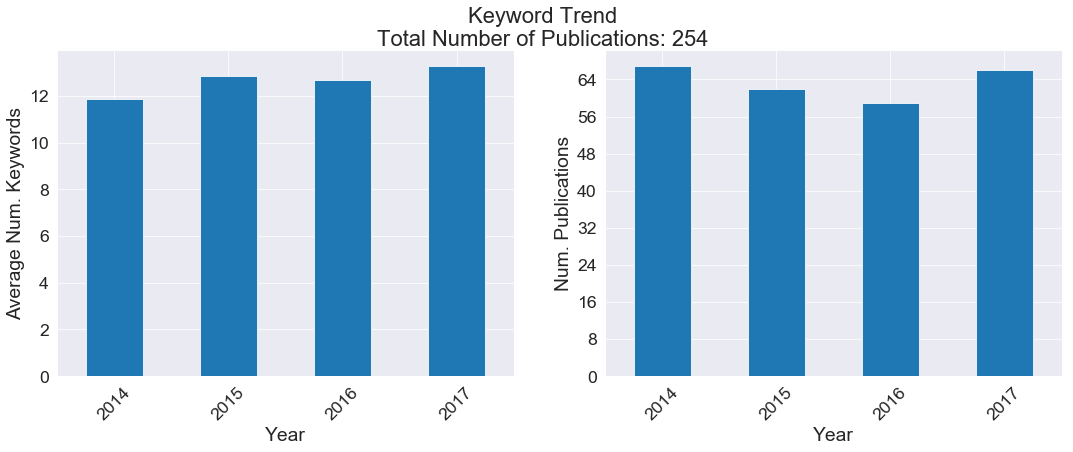

In [17]:
# Plot out the keyword trend. Can save the plot as an image if you give it a file location (will be saved in PNG format)
wos_plot.plot_kw_trend(filtered_corpora, title='Keyword Trend', save_plot_fn=False)

You can also sort the publications into specific criterias.

This matches similar words as found in the title, abstract, and keyword sections.

In [18]:
# Keyword types adapted from Zare et al. (2017)
# http://dx.doi.org/10.1016/j.jhydrol.2017.07.031

criteria = {
    'overarching': set(['uncertainty', 'adapt', 'decision support', 'management', 'gis']),
    'agri': set(['agricultur', 'farm']),
    'water': set(['hydrology', 'water', 'stream', 'aquifer']),
    'enviro': set(['environment', 'climate', 'ecology', 'ecosystem', 'biodivers']),
    'socio_economic': set(['ecosystem service', 'social', 'conflict', 'particip', 'law', 'stakehold', 'policy', 'economic'])
}

crit_matches, crit_summary = wosis.analysis.search.keyword_matches_by_criteria(filtered_corpora, criteria, threshold=95.0)

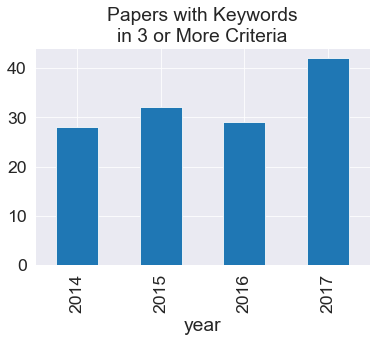

In [19]:
criteria_df = wosis.analysis.search.collate_keyword_criteria_matches(filtered_corpora, crit_matches)
wos_plot.plot_criteria_across_time(criteria_df, threshold=3)

Remember, you can look at the documentation for anything with the question mark magic command

In [20]:
?wos_plot.plot_criteria_across_time

If desired, you can search the publications for a specific keyword (or list of keywords).

Here, we look for some keywords related to the field costs - anything that is 95% similar to the given keywords is acceptable.

In [21]:
matching_records, summary = keyword_matches(filtered_corpora, ['finance', 'costs', 'capita', 'monetary'], threshold=95.0)

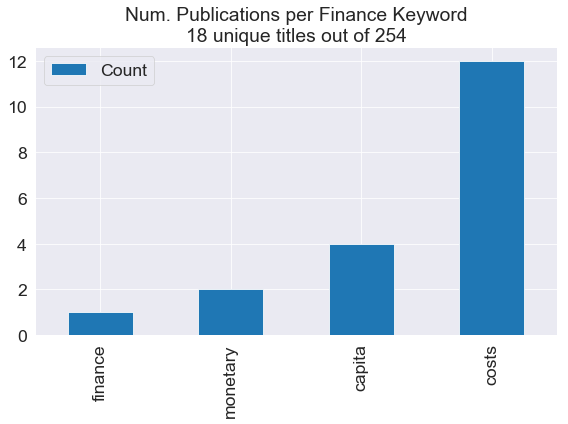

In [22]:
wos_plot.plot_pub_per_kw(matching_records, summary, filtered_corpora, kw_category='Finance')

But the 
We can then attempt to find topics of interest

*WARNING* : This is still under development and the function(s), parameter order, and return types may change

In [23]:
from wosis.analysis import find_topics, get_topic_by_id

filtered_corpora_df = pd.DataFrame(filtered_corpora.forNLP(extraColumns=["AU", "SO", "DE"]))
topic_model, trans, feature_names = find_topics(filtered_corpora_df, num_topics=10)

Topic 1: water river management supply basin resources use quality demand modeling
Topic 2: model models modelling environmental modeling data management framework analysis processes
Topic 3: urban modelling infrastructure water planning drainage systems stormwater tools new
Topic 4: climate change future impacts scenarios changes vulnerability population agricultural hydrological
Topic 5: flood flash rainfall hydrological catchment runoff floods occurrence river events
Topic 6: air traffic pollution emissions emission quality pollutants dispersion stormwater modelling
Topic 7: groundwater flow surface recharge aquifer model low storage water large
Topic 8: energy transport carbon modeling electricity emissions generation nexus planning buildings
Topic 9: land use change soil erosion farm aquatic sediment changes scenarios
Topic 10: irrigation crop stochastic production agricultural demand yield million yields productivity


If the identified topics are too vague or not of interest, try increasing the number of topics. Conversely, if they are too specific, try lowering the number of topics.

Say we're interested in Topic 2. The cell below shows how to get the publications for this topic.

In [24]:
id_of_interesting_topic = 2

topic_set = get_topic_by_id(topic_model, trans, id_of_interesting_topic, filtered_corpora_df)

In [25]:
print("Number of publications in topic set:", len(topic_set))

Number of publications in topic set: 110


In [26]:
# The publication set of interest!
# Hiding keywords and abstract for tutorial (WoS-owned IP)
topic_set.loc[:, ~topic_set.columns.isin(hide_columns)].head(10)  # show first 10

,AU,SO,title,year
0,"Joung, Youn-Kyoung|Noh, Sang Do",CONCURRENT ENGINEERING-RESEARCH AND APPLICATIONS,Integrated modeling and simulation with in-lin...,2014
4,"Romero, Estela|Le Gendre, Romain|Garnier, Jose...",ENVIRONMENTAL SCIENCE & POLICY,Long-term water quality in the lower Seine: Le...,2016
11,"Honti, Mark|Schuwirth, Nele|Rieckermann, Jorg|...",HYDROLOGY AND EARTH SYSTEM SCIENCES,Can integrative catchment management mitigate ...,2017
13,"Bannwarth, M. A.|Grovermann, C.|Schreinemacher...",JOURNAL OF ENVIRONMENTAL MANAGEMENT,Non-hazardous pesticide concentrations in surf...,2016
14,"Rodrigues, M.|Guerreiro, M.|David, L. M.|Olive...",JOURNAL OF ENVIRONMENTAL ENGINEERING,Role of Environmental Forcings on Fecal Contam...,2016
15,"de Brauwere, Anouk|Gourgue, Olivier|de Brye, B...",SCIENCE OF THE TOTAL ENVIRONMENT,Integrated modelling of faecal contamination i...,2014
16,"Sudusinghe, Kishan|Jiao, Yang|Ben Salem, Haifa...",INTERNATIONAL CONFERENCE ON COMPUTATIONAL SCIE...,Multiobjective Design Optimization in the Ligh...,2015
17,"Bandilla, Karl W.|Guo, Bo|Celia, Michael A.|Di...",13TH INTERNATIONAL CONFERENCE ON GREENHOUSE GA...,Applicability of Vertically Integrated Models ...,2017
21,"Semakula, Henry Musoke|Song, Guobao|Achuu, Sim...",ENVIRONMENTAL MODELLING & SOFTWARE,A Bayesian belief network modelling of househo...,2016
25,"Hilty, Lorenz M.|Aebischer, Bernard|Rizzoli, A...",ENVIRONMENTAL MODELLING & SOFTWARE,Modeling and evaluating the sustainability of ...,2014


In [27]:
topic_recs = wosis.extract_recs(topic_set.loc[:, 'id'], RC, 'Topic of Interest')

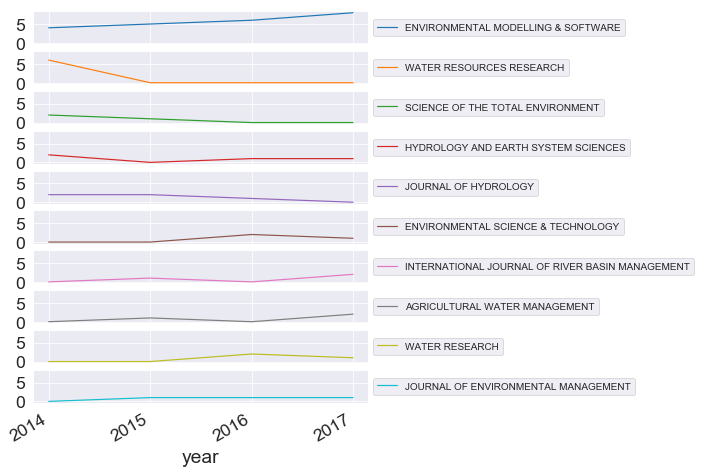

In [28]:
wos_plot.plot_pubs_across_time(topic_recs)

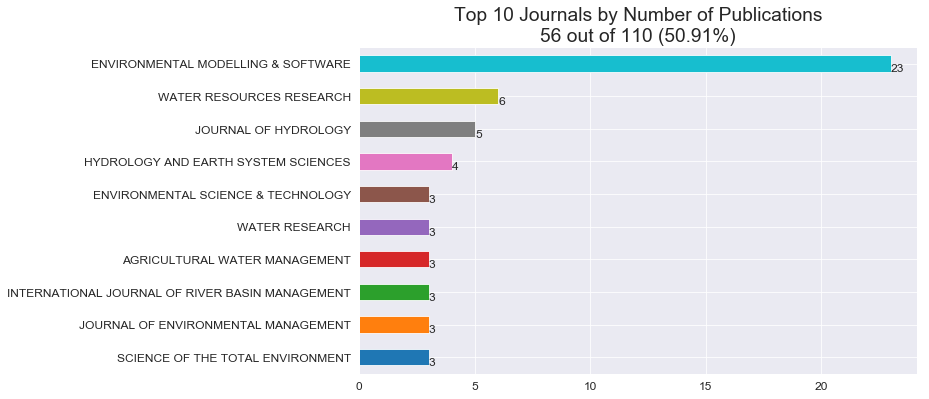

In [29]:
wos_plot.plot_pubs_per_journal(topic_recs, top_n=10, annotate=True, show_stats=True)

Other analysis can easily be accomplished with Pandas

In [32]:
# Top 10 papers count
citation_info = topic_recs.localCiteStats(pandasFriendly=True)
paper_citations = pd.DataFrame(citation_info)
paper_citations = paper_citations.set_index('Citations', drop=True)  # Set the citation name as index
paper_citations = paper_citations.rename(columns={'Counts': 'Citations'})  # Rename 'Count' column to 'Citations'
paper_citations.index.name = 'Publication'  # change name of index to Publication
paper_citations.sort_values(by='Citations', ascending=False)[0:10]

,Citations
Publication,
"Voinov, Alexey, 2013, 'Integronsters', integral and integrated modeling, ENVIRONMENTAL MODELLING & SOFTWARE, 39, 149, 442976565",24
"Jakeman, AJ, 2006, Ten iterative steps in development and evaluation of environmental models, ENVIRONMENTAL MODELLING & SOFTWARE, 21, 602, 66585814",18
"Laniak, Gerard F., 2013, Integrated environmental modeling: A vision and roadmap for the future, ENVIRONMENTAL MODELLING & SOFTWARE, 39, 3, 442976548",18
"Castronova, Anthony M., 2013, Integrated modeling within a Hydrologic Information System: An OpenMI based approach, ENVIRONMENTAL MODELLING & SOFTWARE, 39, 263, 434864554",16
"Argent, RM, 2004, An overview of model integration for environmental application - components, frameworks and semantics, ENVIRONMENTAL MODELLING & SOFTWARE, 19, 219, 495524493",14
"Granell, Carlos, 2013, Seeing the forest through the trees: A review of integrated environmental modelling tools, COMPUTERS ENVIRONMENT AND URBAN SYSTEMS, 41, 136, 459488160",11
"Arnold, JG, 1998, Large area hydrologic modeling and assessment - Part 1: Model development, JOURNAL OF THE AMERICAN WATER RESOURCES ASSOCIATION, 34, 73, 622773",11
"Kelly (Letcher), Rebecca A., 2013, Selecting among five common modelling approaches for integrated environmental assessment and management, ENVIRONMENTAL MODELLING & SOFTWARE, 47, 159, 455902900",11
"Peckham, Scott D., 2013, A component-based approach to integrated modeling in the geosciences: The design of CSDMS, COMPUTERS & GEOSCIENCES, 53, 3, 450501274",11


In [33]:
# Authors with most citations (careful interpreting this - author names are grouped by surname so it is misleading)
author_citations = pd.DataFrame(topic_recs.localCiteStats(pandasFriendly=True, keyType='author'))
author_citations = author_citations.set_index('Citations', drop=True)
author_citations.sort_values(by='Counts', ascending=False).head(10)

,Counts
Citations,
Liu,35
Li,30
Zhang,30
Wang,30
Voinov,28
Arnold,22
Wu,20
Yang,20
Costanza,19
